# More stable value-based methods

In [34]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 60
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('.', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [3]:
torch.cuda.is_available()

True

In [4]:
def get_make_env_fn(**kargs):
    def make_env_fn(env_name, record=False, unwrapped=False ,
                    inner_wrappers=None, outer_wrappers=None,
                    path="videos"):

        env = gym.make(env_name)
        env = env.unwrapped if unwrapped else env
        if inner_wrappers:
            for wrapper in inner_wrappers:
                env = wrapper(env)

        if record:
            return wrappers.RecordVideo(gym.make(env_name), path)


        if outer_wrappers:
            for wrapper in outer_wrappers:
                env = wrapper(env)
        return env
    return make_env_fn, kargs

In [5]:
def get_gif_html(env_videos, title, subtitle_eps=None, max_n_videos=4):
    videos = np.array(env_videos)
    if len(videos) == 0:
        return
    
    n_videos = max(1, min(max_n_videos, len(videos)))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int) if n_videos > 1 else [-1,]
    videos = videos[idxs,...]

    strm = '<h2>{}<h2>'.format(title)
    for i, (video_path, meta_path) in enumerate(videos):
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path,  # input
                 '-r', '7',         # new frame rate
                 '-crf', '20',
                 '-vf', 'scale=512:-1',
                 gif_path)
                 )
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h3>{0}<h3/>
        <img src="data:image/gif;base64,{1}" />"""
        prefix = 'Trial ' if subtitle_eps is None else 'Episode '
        sufix = str(i if subtitle_eps is None \
                    else subtitle_eps[i])
        strm += html_tag.format(prefix + sufix, encoded.decode('ascii'))
    return strm

In [6]:
class GreedyStrategy():
    def __init__(self):
        self.exploratory_action_taken = False

    def select_action(self, model, state):
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            return np.argmax(q_values)

In [7]:
class EGreedyStrategy():
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.exploratory_action_taken = None

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

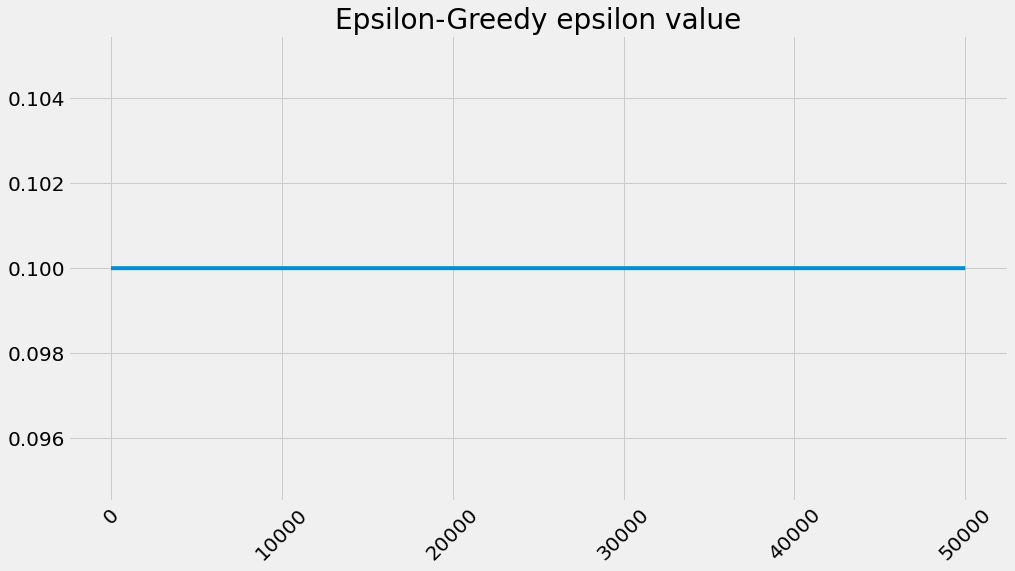

In [8]:
s = EGreedyStrategy()
plt.plot([s.epsilon for _ in range(50000)])
plt.title('Epsilon-Greedy epsilon value')
plt.xticks(rotation=45)
plt.show()

In [10]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        self.t = 0
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.min_epsilon = min_epsilon
        self.decay_steps = decay_steps
        self.exploratory_action_taken = None
        
    def _epsilon_update(self):
        epsilon = 1 - self.t / self.decay_steps
        epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
        epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
        self.t += 1
        return epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else: 
            action = np.random.randint(len(q_values))

        self.epsilon = self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

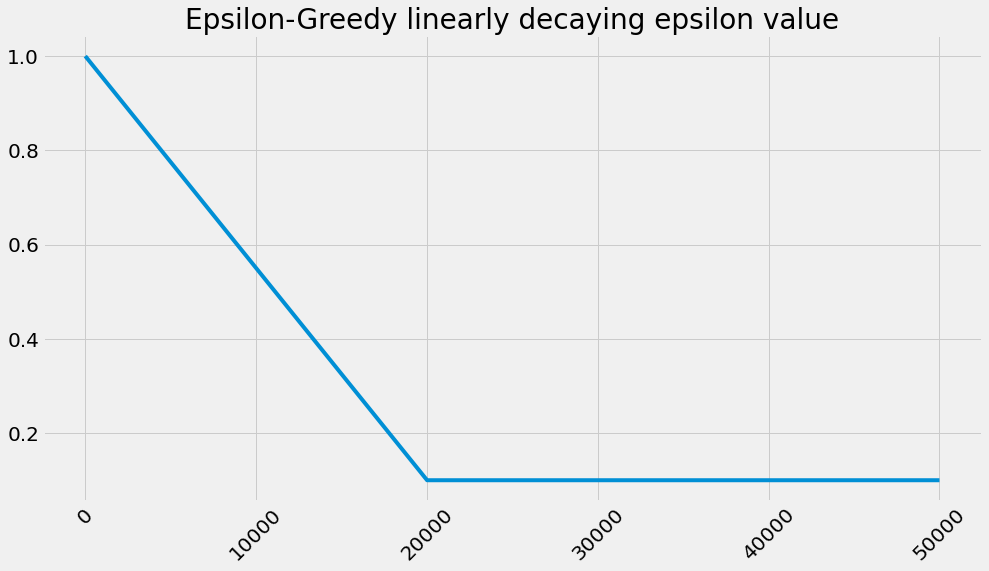

In [11]:
s = EGreedyLinearStrategy()
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy linearly decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In [12]:
class EGreedyExpStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0
        self.exploratory_action_taken = None

    def _epsilon_update(self):
        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        return self.epsilon

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            q_values = model(state).detach().cpu().data.numpy().squeeze()

        if np.random.rand() > self.epsilon:
            action = np.argmax(q_values)
        else:
            action = np.random.randint(len(q_values))

        self._epsilon_update()
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

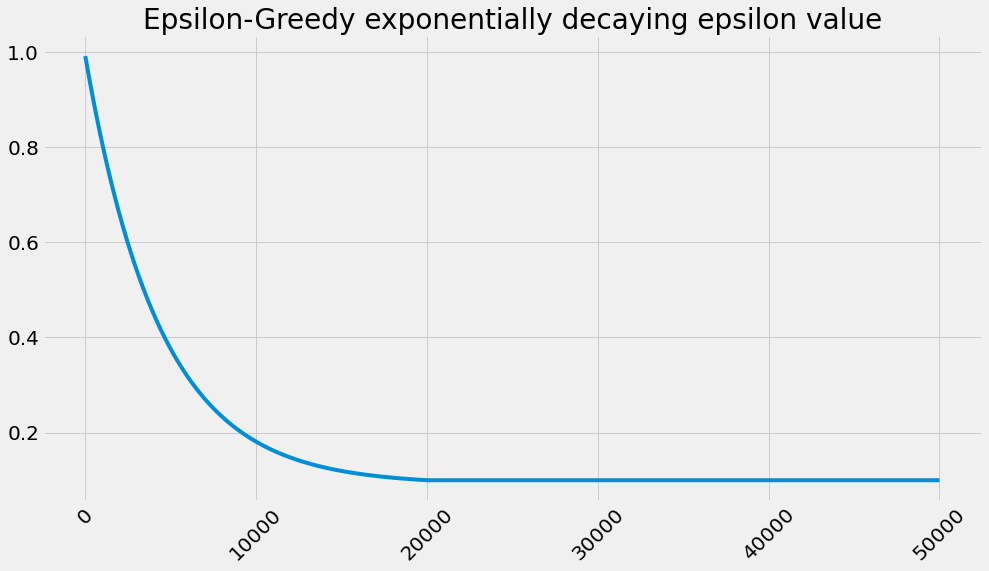

In [13]:
s = EGreedyExpStrategy()
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In [14]:
class SoftMaxStrategy():
    def __init__(self, 
                 init_temp=1.0, 
                 min_temp=0.3, 
                 exploration_ratio=0.8, 
                 max_steps=25000):
        self.t = 0
        self.init_temp = init_temp
        self.exploration_ratio = exploration_ratio
        self.min_temp = min_temp
        self.max_steps = max_steps
        self.exploratory_action_taken = None
        
    def _update_temp(self):
        temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
        temp = (self.init_temp - self.min_temp) * temp + self.min_temp
        temp = np.clip(temp, self.min_temp, self.init_temp)
        self.t += 1
        return temp

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        temp = self._update_temp()

        with torch.no_grad():
            q_values = model(state).cpu().detach().data.numpy().squeeze()
            scaled_qs = q_values/temp
            norm_qs = scaled_qs - scaled_qs.max()            
            e = np.exp(norm_qs)
            probs = e / np.sum(e)
            assert np.isclose(probs.sum(), 1.0)

        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        self.exploratory_action_taken = action != np.argmax(q_values)
        return action

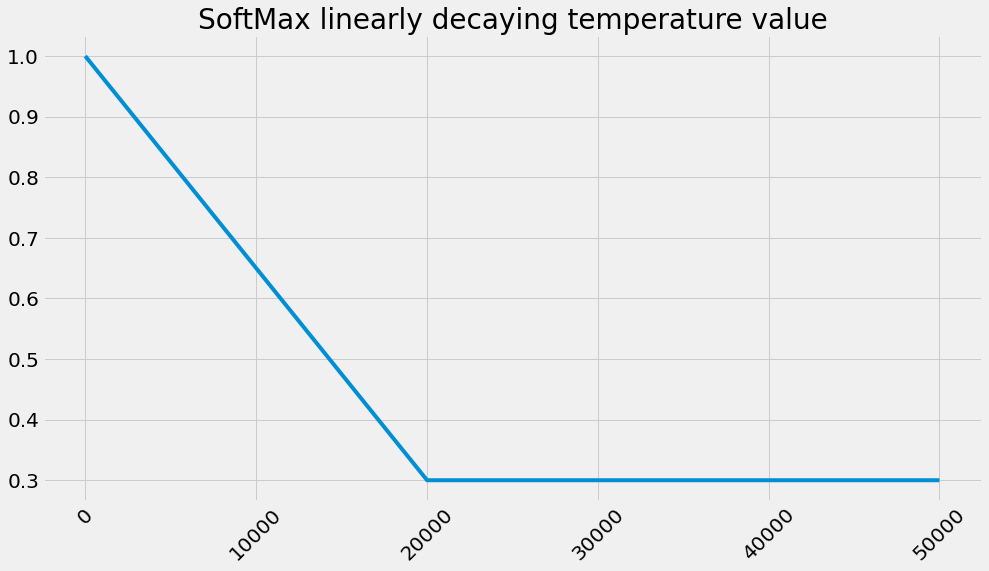

In [15]:
s = SoftMaxStrategy()
plt.plot([s._update_temp() for _ in range(50000)])
plt.title('SoftMax linearly decaying temperature value')
plt.xticks(rotation=45)
plt.show()

## DQN: Making RL more like supervised learning

DQN uses a target network to address the problem of having a non-stationary target by using a *Target Network*

Before using a Target Network:

$\nabla{\theta_i} L_i(\theta_i) = \mathbb{E}_{s, a, r, s'} \Big[ (r + \gamma \max_{a'} Q(s', a'; \theta_i) - Q(s, a; \theta_i)) \nabla_{\theta_i}Q(s, a; \theta_i)\Big]$

After:

$\nabla{\theta_i} L_i(\theta_i) = \mathbb{E}_{s, a, r, s'} \Big[ (r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta_i)) \nabla_{\theta_i}Q(s, a; \theta_i)\Big]$

The only difference is the NN weights that are used to calculate the target. Using a target network, the NN weights used are a previous isntance of the NN that is froozen. This add stability to the updates


By using target networks, it prevents the training process from spiraling around because the target is fixed for multiple time steps, thus allowing the online network weights to move consistenly towards the targets before an update changes the optimization problem



Another way to deal with the non-stationary target issue is to use a large-enough network, although having a larger network costs more compute time

In [17]:
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(FCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        print(f"Using device {device} for {self.__class__.__name__}")
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load(self, experiences):
        states, actions, rewards, new_states, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, rewards, new_states, is_terminals

### Replay Buffers

Experience replay consists of a data structure, often referred to as replay buffer or a replay memory, that holds experience smaples for several steps (much more than 1,024 steps), allowing the sampling of mini-batches from a broad set of past experiences. Having a replay buffer allows the agent two critical things:

1. The training process can use a more diverse mini-batch for performing updates
2. The agent no longer has to fit the model to the same small mini-batch for multiple iterations (epochs)

Adequately sampling a sufficiently large replay buffer yields a slow-moving target, so the agent can now sample and train on every time step with a lower risk of divergence


Replay buffer gradient update. Before adding the replay buffer:

$\nabla_{\theta_i} L_i(\theta_i) = \mathbb{E}_{s, a, r, s'} \Big[ (r + \gamma \max_{a'}Q(s', a'; \theta^-) - Q(s, a; \theta_i) \nabla_{\theta_i}Q(s, a; \theta_i)) \Big]$

After adding the buffer:

$\nabla_{\theta_i} L_i(\theta_i) = \mathbb{E}_{s, a, r, s' \sim \mathbb{U}(D)} \Big[ (r + \gamma \max_{a'}Q(s', a'; \theta^-) - Q(s, a; \theta_i) \nabla_{\theta_i}Q(s, a; \theta_i)) \Big]$

The only difference between the two equations is that, the experiences used for trainig  are obtaining by uniformly random sampling the replay buffer D, instead of using the online experiences as before

This is the full gradient update for DQN, more precisely the one referred to as Nature DQN, which is DQN with a target network and a replay buffer

In [ ]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=10000, 
                 batch_size=64):
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self.batch_size = batch_size
        self._idx = 0
        self.size = 0
    
    def store(self, sample):
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size

        self.size += 1
        self.size = min(self.size, self.max_size)

    def sample(self, batch_size=None):
        if batch_size == None:
            batch_size = self.batch_size

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        experiences = np.vstack(self.ss_mem[idxs]), \
                      np.vstack(self.as_mem[idxs]), \
                      np.vstack(self.rs_mem[idxs]), \
                      np.vstack(self.ps_mem[idxs]), \
                      np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

In [26]:
class DQN():
    def __init__(self, 
                 replay_buffer_fn, 
                 value_model_fn, 
                 value_optimizer_fn, 
                 value_optimizer_lr,
                 training_strategy_fn,
                 evaluation_strategy_fn,
                 n_warmup_batches,
                 update_target_every_steps):
        self.replay_buffer_fn = replay_buffer_fn
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.training_strategy_fn = training_strategy_fn
        self.evaluation_strategy_fn = evaluation_strategy_fn
        self.n_warmup_batches = n_warmup_batches
        self.update_target_every_steps = update_target_every_steps
    
    def optimize_model(self, experiences):
        states, actions, rewards, next_states, is_terminals = experiences

        batch_size = len(is_terminals)

        # use the target network to get estimate of
        # next state (to calculate the target)
        q_sp = self.target_model(next_states).detach()
        # get the maximum
        max_a_q_sp = q_sp.max(1)[0].unsqueeze(1)
        max_a_q_sp *= (1 - is_terminals)

        # get the TD targets
        target_q_sa = rewards + self.gamma * max_a_q_sp
        # get the estimate of the current "online" model
        q_sa = self.online_model(states).gather(1, actions)
        # get the error
        td_error = q_sa - target_q_sa
        # loss
        value_loss = td_error.pow(2).mul(0.5).mean()

        # optimize the online network
        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()


    def interaction_step(self, state, env):
        # use the online model to select actions
        action = self.training_strategy.select_action(self.online_model, state)
        new_state, reward, is_terminal, info = env.step(action)
        # if the episode was terminated by timelimit, then 
        # it should not be seen as a 'failure'
        is_truncated = "TimeLimit.truncated" in info and info['TimeLimit.truncated']
        is_failure = is_terminal and not is_truncated
        experience = (state, action, reward, new_state, float(is_failure))

        self.replay_buffer.store(experience)
        self.episode_reward[-1] += reward
        self.episode_timestep[-1] += 1
        self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)

        return new_state, is_terminal
    

    def update_network(self):
        # this is how the target network (lagging network)
        # get updated with the online network 
        for target, online in zip(self.target_model.parameters(),
                                    self.online_model.parameters()):
            # copy the weights of the current
            # network to the target network
            target.data.copy_(online.data)
    

    def train(self, make_env_fn, make_env_kargs, seed, gamma,
                max_minutes, max_episodes, goal_mean_100_reward):
        training_start, last_debug_time = time.time(), float('-inf')

        self.checkpoint_dir = tempfile.mkdtemp()
        self.make_env_fn = make_env_fn
        self.make_env_kargs = make_env_kargs
        self.seed = seed
        self.gamma = gamma

        env = self.make_env_fn(**self.make_env_kargs)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

        nS, nA = env.observation_space.shape[0], env.action_space.n
        self.episode_timestep = []
        self.episode_reward = []
        self.episode_seconds = []
        self.evaluation_scores = []
        self.episode_exploration = []

        self.target_model = self.value_model_fn(nS, nA)
        self.online_model = self.value_model_fn(nS, nA)
        # start off with the same weights
        self.update_network()

        self.value_optimizer = self.value_optimizer_fn(self.online_model,
                                                    self.value_optimizer_lr)
        
        self.replay_buffer = self.replay_buffer_fn()
        self.training_strategy = self.training_strategy_fn()
        self.evaluation_strategy = self.evaluation_strategy_fn()

        result = np.empty((max_episodes, 5))
        result[:] = np.nan
        training_time = 0
        for episode in range(1, max_episodes + 1):
            episode_start = time.time()

            state, is_terminal = env.reset(), False
            self.episode_reward.append(0.0)
            self.episode_timestep.append(0.0)
            self.episode_exploration.append(0.0)

            for step in count():
                state, is_terminal = self.interaction_step(state, env)

                min_samples = self.replay_buffer.batch_size * self.n_warmup_batches
                if len(self.replay_buffer) > min_samples:
                    experiences = self.replay_buffer.sample()
                    experiences = self.online_model.load(experiences)
                    self.optimize_model(experiences)
                
                if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
                    self.update_network()
                
                if is_terminal:
                    gc.collect()
                    break
            
            # stats
            episode_elapsed = time.time() - episode_start
            self.episode_seconds.append(episode_elapsed)
            training_time += episode_elapsed
            evaluation_score, _ = self.evaluate(self.online_model, env)
            self.save_checkpoint(episode-1, self.online_model)
            
            total_step = int(np.sum(self.episode_timestep))
            self.evaluation_scores.append(evaluation_score)
            
            mean_10_reward = np.mean(self.episode_reward[-10:])
            std_10_reward = np.std(self.episode_reward[-10:])
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            lst_100_exp_rat = np.array(
                self.episode_exploration[-100:])/np.array(self.episode_timestep[-100:])
            mean_100_exp_rat = np.mean(lst_100_exp_rat)
            std_100_exp_rat = np.std(lst_100_exp_rat)
            
            wallclock_elapsed = time.time() - training_start
            result[episode-1] = total_step, mean_100_reward, \
                mean_100_eval_score, training_time, wallclock_elapsed
            
            reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
            reached_max_minutes = wallclock_elapsed >= max_minutes * 60
            reached_max_episodes = episode >= max_episodes
            reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
            training_is_over = reached_max_minutes or \
                               reached_max_episodes or \
                               reached_goal_mean_reward

            elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            debug_message = 'el {}, ep {:04}, ts {:06}, '
            debug_message += 'ar 10 {:05.1f}\u00B1{:05.1f}, '
            debug_message += '100 {:05.1f}\u00B1{:05.1f}, '
            debug_message += 'ex 100 {:02.1f}\u00B1{:02.1f}, '
            debug_message += 'ev {:05.1f}\u00B1{:05.1f}'
            debug_message = debug_message.format(
                elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward, 
                mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
                mean_100_eval_score, std_100_eval_score)
            print(debug_message, end='\r', flush=True)
            if reached_debug_time or training_is_over:
                print(ERASE_LINE + debug_message, flush=True)
                last_debug_time = time.time()
            if training_is_over:
                if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
                if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
                if reached_goal_mean_reward: print(u'--> reached_goal_mean_reward \u2713')
                break
        

        final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
        wallclock_time = time.time() - training_start
        print('Training complete.')
        print('Final evaluation score {:.2f}\u00B1{:.2f} in {:.2f}s training time,'
              ' {:.2f}s wall-clock time.\n'.format(
                  final_eval_score, score_std, training_time, wallclock_time))
        env.close() ; del env
        self.get_cleaned_checkpoints()
        return result, final_eval_score, training_time, wallclock_time
    


    def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
        rs = []
        for _ in range(n_episodes):
            s, d = eval_env.reset(), False
            rs.append(0)

            for _ in count():
                a = self.evaluation_strategy.select_action(eval_policy_model, s)
                s, r, d, _ = eval_env.step(a)
                rs[-1] += r
                if d: break
        
        return np.mean(rs), np.std(rs)
    

    def get_cleaned_checkpoints(self, n_checkpoints=5):
        try:
            return self.checkpoint_paths
        except AttributeError:
            self.checkpoint_paths = {}
        
        paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
        paths_dic = {int(path.split('.')[-2]): path for path in paths}
        last_ep = max(paths_dic.keys())
        checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=int)-1

        for idx, path in paths_dic.items():
            if idx in checkpoint_idxs:
                self.checkpoint_paths[idx] = path
            else:
                os.unlink(path)
        
        return self.checkpoint_paths

    def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
        checkpoint_paths = self.get_cleaned_checkpoints()
        last_ep = max(checkpoint_paths.keys())
        self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

        videos = []
        for i in range(n_episodes):
            path = f".videos/videos-demo-last-{i}"
            env = self.make_env_fn(**self.make_env_kargs, record=True, path=path)
            self.evaluate(self.online_model, env, n_episodes=1)
            env.close()
            del env
            videos.append((path + "/rl-video-episode-0.mp4", path + "/rl-video-episode-0.meta.json"))

        data = get_gif_html(env_videos=videos, 
                            title=title.format(self.__class__.__name__),
                            max_n_videos=max_n_videos)
        return HTML(data=data)


    def demo_progression(self, title='{} Agent progression', max_n_videos=5):
        checkpoint_paths = self.get_cleaned_checkpoints()

        videos = []
        for i in sorted(checkpoint_paths.keys()):  
            path = f".videos/videos-{i}"
            env = self.make_env_fn(**self.make_env_kargs, path=path, record=True)
            self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
            self.evaluate(self.online_model, env, n_episodes=1)
            env.close()
            del env 
            videos.append((path + "/rl-video-episode-0.mp4", path + "/rl-video-episode-0.meta.json"))

        data = get_gif_html(env_videos=videos,
                            title=title.format(self.__class__.__name__),
                            subtitle_eps=sorted(checkpoint_paths.keys()),
                            max_n_videos=max_n_videos)

        return HTML(data=data)

    
    def save_checkpoint(self, episode_idx, model):
        torch.save(model.state_dict(),
                    os.path.join(self.checkpoint_dir, 'model.{}.tar'.format(episode_idx)))

In [27]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 10000,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    # training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # training_strategy_fn = lambda: EGreedyLinearStrategy(init_epsilon=1.0,
    #                                                      min_epsilon=0.3, 
    #                                                      max_steps=20000)
    # training_strategy_fn = lambda: SoftMaxStrategy(init_temp=1.0, 
    #                                                min_temp=0.1, 
    #                                                exploration_ratio=0.8, 
    #                                                max_steps=20000)
    training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,  
                                                      min_epsilon=0.3, 
                                                      decay_steps=20000)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
    n_warmup_batches = 5
    update_target_every_steps = 10

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = DQN(replay_buffer_fn,
                value_model_fn,
                value_optimizer_fn,
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                n_warmup_batches,
                update_target_every_steps)

    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    dqn_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
dqn_results = np.array(dqn_results)
_ = BEEP()

Using device cuda:0 for FCQ
Using device cuda:0 for FCQ
el 00:00:00, ep 0000, ts 000016, ar 10 016.0±000.0, 100 016.0±000.0, ex 100 0.4±0.0, ev 021.0±000.0
el 00:01:00, ep 0150, ts 013125, ar 10 266.4±070.4, 100 117.5±094.3, ex 100 0.3±0.1, ev 309.1±110.9
el 00:02:00, ep 0198, ts 029491, ar 10 460.1±090.7, 100 256.1±137.1, ex 100 0.2±0.1, ev 357.0±121.5
el 00:03:02, ep 0233, ts 045158, ar 10 497.6±007.2, 100 358.8±140.6, ex 100 0.2±0.0, ev 423.1±109.1
el 00:04:03, ep 0266, ts 059613, ar 10 450.3±079.0, 100 422.6±121.9, ex 100 0.2±0.0, ev 474.2±073.8
el 00:04:07, ep 0268, ts 060613, ar 10 466.4±070.7, 100 426.7±120.4, ex 100 0.2±0.0, ev 476.2±072.2
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 216.21s training time, 263.60s wall-clock time.

Using device cuda:0 for FCQ
Using device cuda:0 for FCQ
el 00:00:00, ep 0000, ts 000023, ar 10 023.0±000.0, 100 023.0±000.0, ex 100 0.6±0.0, ev 008.0±000.0


C:\Users\danie\AppData\Local\Temp\ipykernel_10836\192980936.py:226: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int)-1


el 00:01:00, ep 0152, ts 013008, ar 10 213.3±034.5, 100 113.6±083.2, ex 100 0.3±0.1, ev 305.9±107.2
el 00:02:01, ep 0214, ts 029234, ar 10 476.9±069.3, 100 236.7±123.9, ex 100 0.2±0.0, ev 332.8±121.3
el 00:03:01, ep 0247, ts 044649, ar 10 461.5±115.5, 100 326.9±160.4, ex 100 0.2±0.0, ev 392.3±130.6
el 00:04:01, ep 0277, ts 059042, ar 10 459.9±114.7, 100 414.0±141.6, ex 100 0.2±0.0, ev 459.3±097.3
el 00:04:14, ep 0283, ts 062042, ar 10 500.0±000.0, 100 430.9±133.3, ex 100 0.2±0.0, ev 476.1±075.3
--> reached_goal_mean_reward ✓
Training complete.
Final evaluation score 500.00±0.00 in 221.31s training time, 271.01s wall-clock time.

Using device cuda:0 for FCQ
Using device cuda:0 for FCQ
el 00:00:00, ep 0000, ts 000013, ar 10 013.0±000.0, 100 013.0±000.0, ex 100 0.6±0.0, ev 010.0±000.0
el 00:01:00, ep 0142, ts 014416, ar 10 331.7±139.2, 100 132.2±116.7, ex 100 0.3±0.1, ev 283.6±119.1
el 00:02:01, ep 0177, ts 031295, ar 10 489.2±021.6, 100 284.9±176.2, ex 100 0.2±0.1, ev 387.2±122.1
el 00:0


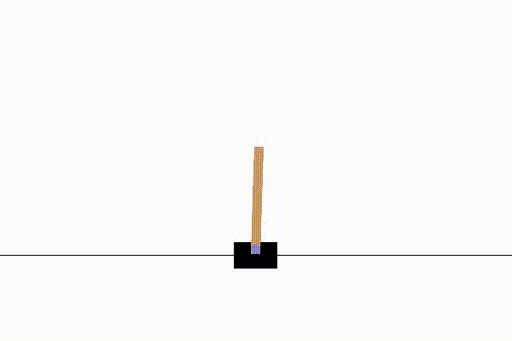
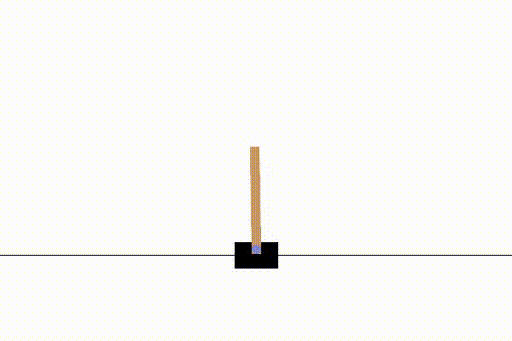
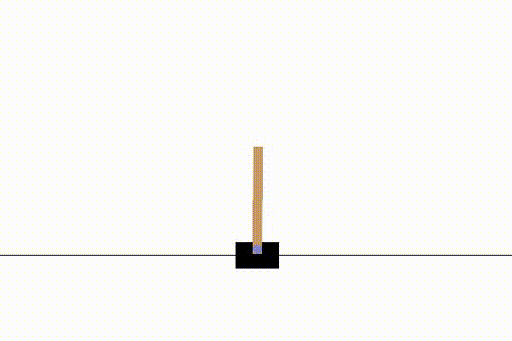
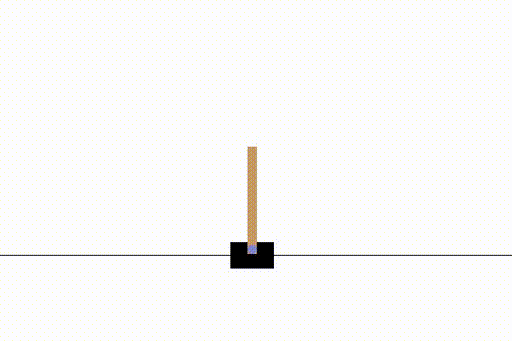
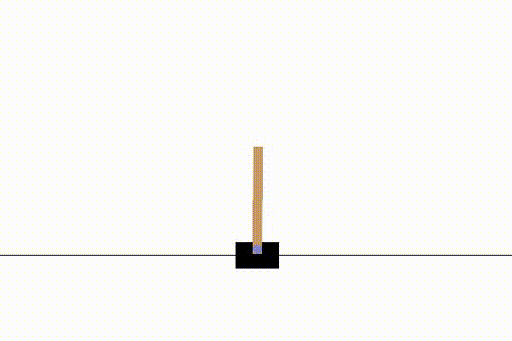

In [31]:
best_agent.demo_progression()


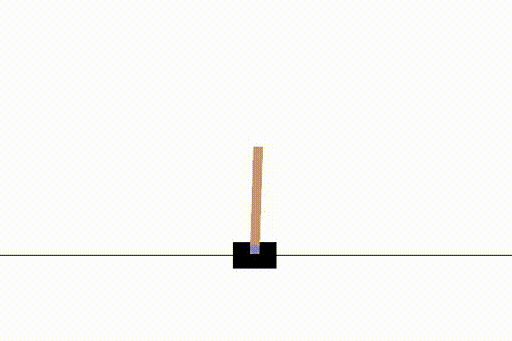
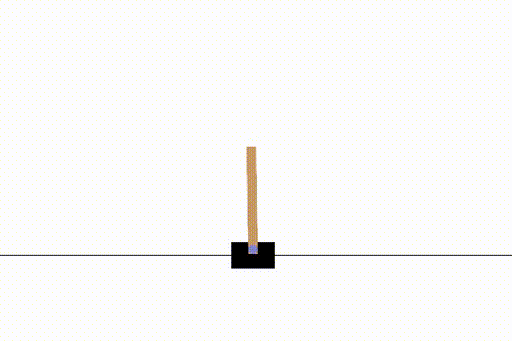
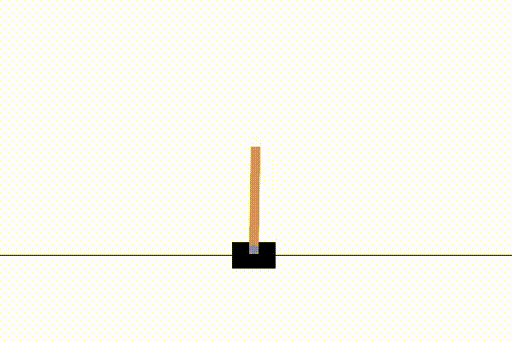

In [32]:
best_agent.demo_last()

In [36]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
nfq_x = np.load(os.path.join(nfq_root_dir, 'x.npy'))

nfq_max_r = np.load(os.path.join(nfq_root_dir, 'max_r.npy'))
nfq_min_r = np.load(os.path.join(nfq_root_dir, 'min_r.npy'))
nfq_mean_r = np.load(os.path.join(nfq_root_dir, 'mean_r.npy'))

nfq_max_s = np.load(os.path.join(nfq_root_dir, 'max_s.npy'))
nfq_min_s = np.load(os.path.join(nfq_root_dir, 'min_s.npy'))
nfq_mean_s = np.load(os.path.join(nfq_root_dir, 'mean_s.npy'))

nfq_max_t = np.load(os.path.join(nfq_root_dir, 'max_t.npy'))
nfq_min_t = np.load(os.path.join(nfq_root_dir, 'min_t.npy'))
nfq_mean_t = np.load(os.path.join(nfq_root_dir, 'mean_t.npy'))

nfq_max_sec = np.load(os.path.join(nfq_root_dir, 'max_sec.npy'))
nfq_min_sec = np.load(os.path.join(nfq_root_dir, 'min_sec.npy'))
nfq_mean_sec = np.load(os.path.join(nfq_root_dir, 'mean_sec.npy'))

nfq_max_rt = np.load(os.path.join(nfq_root_dir, 'max_rt.npy'))
nfq_min_rt = np.load(os.path.join(nfq_root_dir, 'min_rt.npy'))
nfq_mean_rt = np.load(os.path.join(nfq_root_dir, 'mean_rt.npy'))

In [37]:
dqn_max_t, dqn_max_r, dqn_max_s, \
    dqn_max_sec, dqn_max_rt = np.max(dqn_results, axis=0).T
dqn_min_t, dqn_min_r, dqn_min_s, \
    dqn_min_sec, dqn_min_rt = np.min(dqn_results, axis=0).T
dqn_mean_t, dqn_mean_r, dqn_mean_s, \
    dqn_mean_sec, dqn_mean_rt = np.mean(dqn_results, axis=0).T
dqn_x = np.arange(np.max((len(dqn_mean_s), len(nfq_mean_s))))

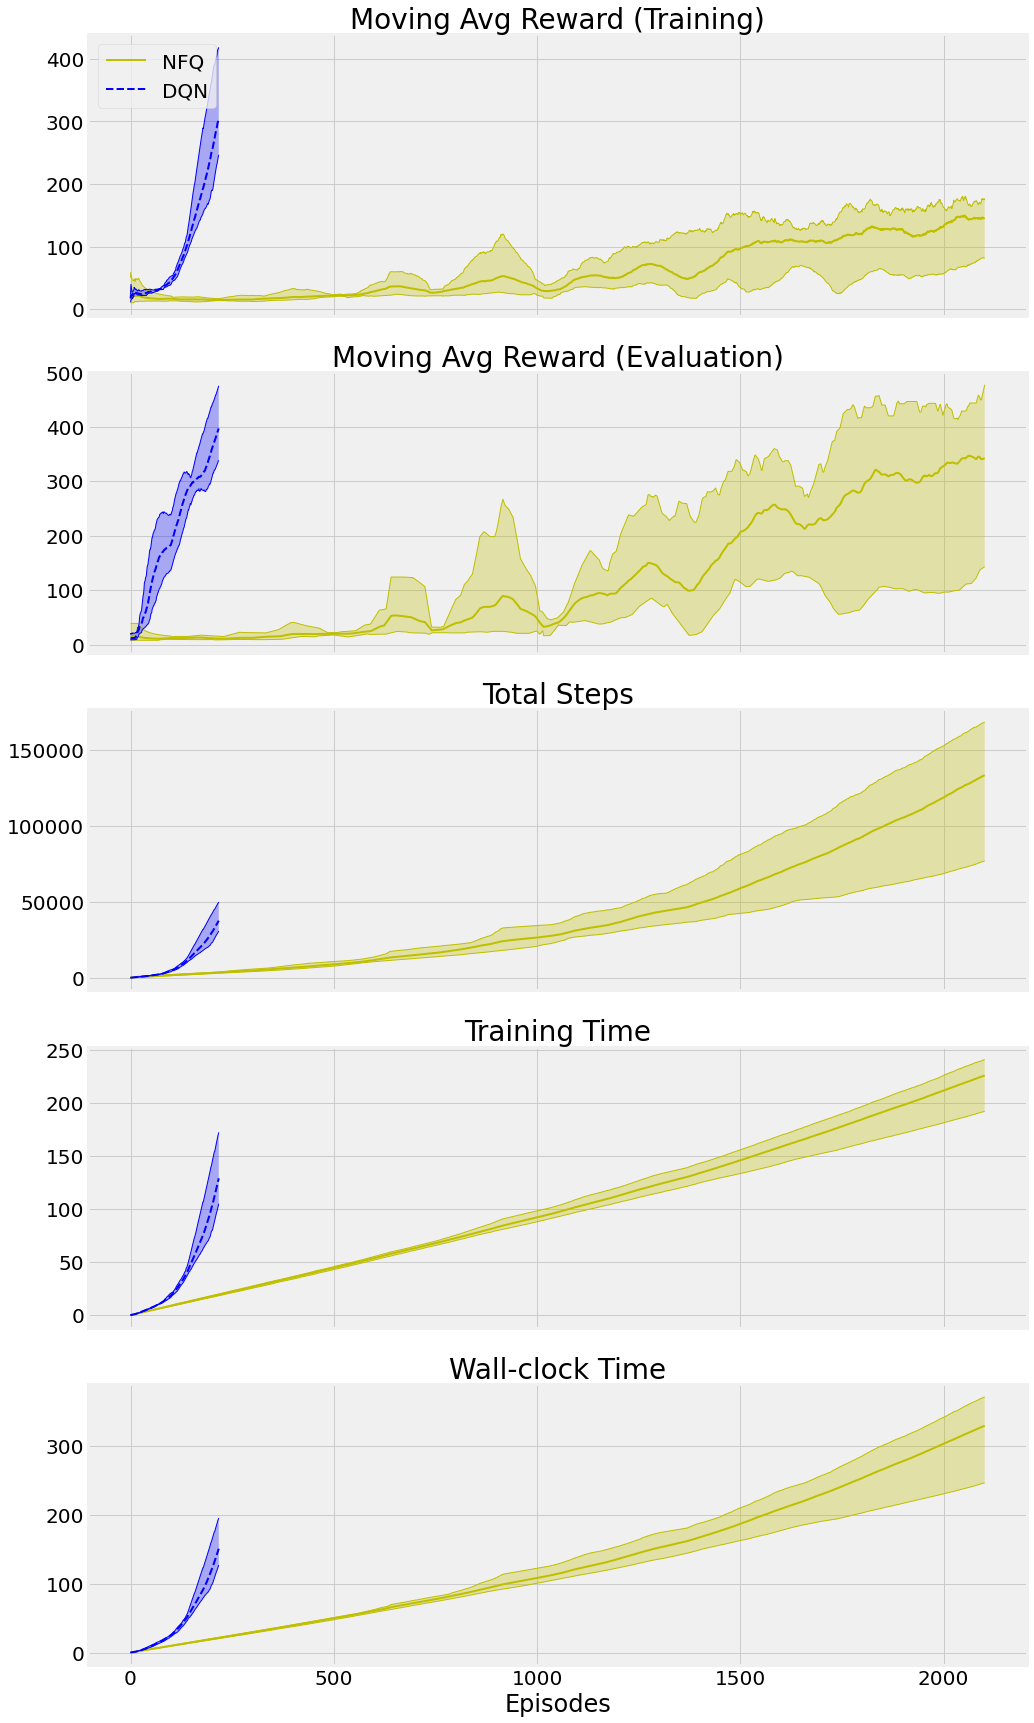

In [41]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# DQN
axs[0].plot(dqn_max_r, 'b', linewidth=1)
axs[0].plot(dqn_min_r, 'b', linewidth=1)
axs[0].plot(dqn_mean_r, 'b--', label='DQN', linewidth=2)
axs[0].fill_between(dqn_x, dqn_min_r, dqn_max_r, facecolor='b', alpha=0.3)

axs[1].plot(dqn_max_s, 'b', linewidth=1)
axs[1].plot(dqn_min_s, 'b', linewidth=1)
axs[1].plot(dqn_mean_s, 'b--', label='DQN', linewidth=2)
axs[1].fill_between(dqn_x, dqn_min_s, dqn_max_s, facecolor='b', alpha=0.3)

axs[2].plot(dqn_max_t, 'b', linewidth=1)
axs[2].plot(dqn_min_t, 'b', linewidth=1)
axs[2].plot(dqn_mean_t, 'b--', label='DQN', linewidth=2)
axs[2].fill_between(dqn_x, dqn_min_t, dqn_max_t, facecolor='b', alpha=0.3)

axs[3].plot(dqn_max_sec, 'b', linewidth=1)
axs[3].plot(dqn_min_sec, 'b', linewidth=1)
axs[3].plot(dqn_mean_sec, 'b--', label='DQN', linewidth=2)
axs[3].fill_between(dqn_x, dqn_min_sec, dqn_max_sec, facecolor='b', alpha=0.3)

axs[4].plot(dqn_max_rt, 'b', linewidth=1)
axs[4].plot(dqn_min_rt, 'b', linewidth=1)
axs[4].plot(dqn_mean_rt, 'b--', label='DQN', linewidth=2)
axs[4].fill_between(dqn_x, dqn_min_rt, dqn_max_rt, facecolor='b', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [39]:
dqn_root_dir = os.path.join(RESULTS_DIR, 'dqn')
not os.path.exists(dqn_root_dir) and os.makedirs(dqn_root_dir)

np.save(os.path.join(dqn_root_dir, 'x'), dqn_x)

np.save(os.path.join(dqn_root_dir, 'max_r'), dqn_max_r)
np.save(os.path.join(dqn_root_dir, 'min_r'), dqn_min_r)
np.save(os.path.join(dqn_root_dir, 'mean_r'), dqn_mean_r)

np.save(os.path.join(dqn_root_dir, 'max_s'), dqn_max_s)
np.save(os.path.join(dqn_root_dir, 'min_s'), dqn_min_s )
np.save(os.path.join(dqn_root_dir, 'mean_s'), dqn_mean_s)

np.save(os.path.join(dqn_root_dir, 'max_t'), dqn_max_t)
np.save(os.path.join(dqn_root_dir, 'min_t'), dqn_min_t)
np.save(os.path.join(dqn_root_dir, 'mean_t'), dqn_mean_t)

np.save(os.path.join(dqn_root_dir, 'max_sec'), dqn_max_sec)
np.save(os.path.join(dqn_root_dir, 'min_sec'), dqn_min_sec)
np.save(os.path.join(dqn_root_dir, 'mean_sec'), dqn_mean_sec)

np.save(os.path.join(dqn_root_dir, 'max_rt'), dqn_max_rt)
np.save(os.path.join(dqn_root_dir, 'min_rt'), dqn_min_rt)
np.save(os.path.join(dqn_root_dir, 'mean_rt'), dqn_mean_rt)